# Evaluate Pilot with Multiple-Choice Questions

In [1]:
# import
import os
os.chdir("./..")
import json
import numpy as np
from util import filters
from datetime import datetime
from util.filters import FORMAT, LIKERT_CONVERTER, CONDITIONS

from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file = "pilot_09_06_complete.json"
with open("./prolific_logs/" + file) as f:
    logs = json.load(f)
logs = [logs["logs"][l] for l in logs["logs"]]

### Add Initial Pilot
The initial pilot was identical to the following 60 samples. Except with the difference that there was one less multiple-choice question. 

In [3]:
# OPTIONAL: INTEGRATE OLD LOGS INTO DATA
if True:
    file = "pilot_09_05_complete.json"
    with open("./prolific_logs/" + file) as f:
        old_logs = json.load(f)
    old_logs = [old_logs["logs"][l] for l in old_logs["logs"]]
    old_logs = [l for l in old_logs if l["completedSurvey"] == True]

    # Renumber questions
    for l in old_logs:
        del l["knowledgeAnswers"]["q1"]
        for i in range(1, 9):
            l["knowledgeAnswers"]["q" + str(i)] = l["knowledgeAnswers"]["q" + str(i + 1)]
        del l["knowledgeAnswers"]["q9"]
    
    # Add into new logs
    logs += old_logs

#### -------------------------------------------------------------------------

In [4]:
# helper function
def get_avg_std_err(vals):
    mean = np.mean(vals)
    std_dev = np.std(vals, ddof=1)  # Using ddof=1 for sample standard deviation
    
    # Calculate the standard error using the formula: standard deviation / sqrt(sample size)
    standard_error = std_dev / np.sqrt(len(vals))
    return mean, standard_error

## Data Preprocessing

In [5]:
# only consider completed sessions
print("Before filtering")
print("all logs:", len(logs))
for c in CONDITIONS:
    print(c, len([l for l in logs if l["condition"] == c]))


logs = [l for l in logs if l["completedSurvey"] == True]

print("\nAfter filtering")
print("completed logs:", len(logs))
for c in CONDITIONS:
    print(c, len([l for l in logs if l["condition"] == c]))

Before filtering
all logs: 141
reading 36
teacher-qa-bot 33
llm-qa-bot 34
llm-chatbot 38

After filtering
completed logs: 100
reading 30
teacher-qa-bot 17
llm-qa-bot 23
llm-chatbot 30


### Prepare table for grading

In [6]:
# EXPORT GRADING TABLE HERE
def essay_answer(log, q_id):
    return log["knowledgeAnswers"][q_id]["answer"].replace("\t", "").replace("\n", " ")

csv_string = ""

header = "uuid\tcondition"
header += "\t" + "Answer " + "\tMeng " + "\tRobin "
csv_string += header + "\n"

for l in logs:
    c = l["condition"]
    line = ""
    csv_string += l["uuid"] + "\t" + c
    for q_id in ["q8"]:
        csv_string += "\t" + essay_answer(l, q_id) + "\t\t"
    csv_string += line + "\n"


print(csv_string)
with open('multiple_choice_data.tsv', 'w') as file:
    file.write(csv_string)

uuid	condition	Answer 	Meng 	Robin 
1202659a-703a-4fef-aadd-d36814c7f413	llm-qa-bot	Protein synthesis is necessary because proteins are used in a variety of vital bodily functions. For instance, enzymes are proteins which allow us to digest certain foods.		
1d7199c3-e58e-47bc-bb28-58775f7b5e92	reading	Protein breaks down to amino acids which the body converts into energy.		
1f1c2bbe-5e24-4209-84a7-fa7aca9ea7f3	llm-chatbot	To make amino acids		
215f52a6-6312-4fcc-b2fa-3e6ca851d705	reading	Protein synthesis is very necessary because our bodies would not be able to function without it.  Protein helps produce amino acids and enzymes, like those produced in the pancreas, that are necessary for us to survive.		
21d607a4-b185-4cc4-af10-7e68d6e5a9eb	llm-chatbot	Its a nutrient that is important to grow cells.		
267d7527-a106-4103-bef6-4ba064cb0062	reading	Protein synthesis is necessary because it is important in order for other parts of the cell to function, such as the mitochondria which produ

In [7]:
# demographics functions

def demograph_distribution(logs, q_id):
    categories = {k: 0.0 for k in logs[0]["demographicsAnswers"][q_id]["choices"]}
    for l in logs:
        categories[l["demographicsAnswers"][q_id]["answer"]] += 1
    for k in categories:
        categories[k] /= len(logs)
    return categories


for q_id in ["q1", "q2", "q3", "q4", "q5", "q6"]:
    distribution = demograph_distribution(logs, q_id)
    question = logs[0]["demographicsAnswers"][q_id]["question"]
    print(question)
    print(distribution)
    print("")


<span>Q1: What is your age?</span>
{'18 - 25': 0.14, '26 - 35': 0.34, '36 - 45': 0.25, '46 - 55': 0.19, 'Over 55': 0.08}

<span>Q2: What is your gender?</span>
{'Male': 0.52, 'Female': 0.44, 'Other': 0.04}

<span>Q3: What was the subject of the lesson assigned to you?</span>
{'Business': 0.03, 'Chemistry': 0.03, 'Physics': 0.02, 'Biology': 0.92, 'Psychology': 0.0}

<span>Q4: What is your highest educational degree?</span>
{'Primary/Elementary School': 0.0, 'Some High School': 0.0, 'High School Diploma or Equivalent': 0.36, "Bachelor's/Professional Degree": 0.45, "Master's Degree or Higher": 0.19}

<span>Q5: What is your field of work/study?</span>
{'Engineering': 0.02, 'Computer Science': 0.2, 'Business/Management': 0.18, 'Humanities': 0.05, 'Social Sciences': 0.05, 'Natural Sciences': 0.02, 'Arts': 0.08, 'Health/Medicine': 0.06, 'Education': 0.05, 'Other': 0.29}

<span>Q6: What type of device did you use to complete this study?</span>
{'Smartphone': 0.0, 'Desktop/Laptop': 1.0, 'Tablet

In [8]:
logs[0]["demographicsAnswers"]

{'q1': {'answer': '18 - 25',
  'choices': ['18 - 25', '26 - 35', '36 - 45', '46 - 55', 'Over 55'],
  'question': '<span>Q1: What is your age?</span>'},
 'q2': {'answer': 'Male',
  'choices': ['Male', 'Female', 'Other'],
  'question': '<span>Q2: What is your gender?</span>'},
 'q3': {'answer': 'Biology',
  'choices': ['Business', 'Chemistry', 'Physics', 'Biology', 'Psychology'],
  'question': '<span>Q3: What was the subject of the lesson assigned to you?</span>'},
 'q4': {'answer': 'High School Diploma or Equivalent',
  'choices': ['Primary/Elementary School',
   'Some High School',
   'High School Diploma or Equivalent',
   "Bachelor's/Professional Degree",
   "Master's Degree or Higher"],
  'question': '<span>Q4: What is your highest educational degree?</span>'},
 'q5': {'answer': 'Computer Science',
  'choices': ['Engineering',
   'Computer Science',
   'Business/Management',
   'Humanities',
   'Social Sciences',
   'Natural Sciences',
   'Arts',
   'Health/Medicine',
   'Education'

#### -------------------------------------------------------------

In [9]:
# NOTE: Filter sequence  | ADJUST AS DESIRED
print("n logs before filter:", len(logs))
for c in CONDITIONS:
    print(c, len([l for l in logs if l["condition"] == c]))

logs = [l for l in logs if filters.got_subject_right(l)]
logs = [l for l in logs if filters.got_device_right(l)]
logs = [l for l in logs if filters.got_valid_degree(l)]
logs = [l for l in logs if filters.did_not_cheat(l)]
logs = [l for l in logs if filters.no_tab_switch_during_exam(l)]

print("\nn logs after filter:", len(logs))
for c in CONDITIONS:
    print(c, len([l for l in logs if l["condition"] == c]))

n logs before filter: 100
reading 30
teacher-qa-bot 17
llm-qa-bot 23
llm-chatbot 30

n logs after filter: 58
reading 15
teacher-qa-bot 7
llm-qa-bot 15
llm-chatbot 21


## Evaluate performance data

In [10]:
# NOTE: Compute Post-test scores
def survey_score(log):
    # print(log["knowledgeAnswers"])
    score = 0
    for q in log["knowledgeAnswers"]:
        if q == "q8":
            continue

        score += (log["knowledgeAnswers"][q]["answer"] == log["knowledgeAnswers"][q]["solution"])
    return score

mean, err = get_avg_std_err([survey_score(l) for l in logs])
print("Overall average:  " + str(round(mean, 2)) + "  ± " + str(round(err, 2)))
print("")
group_scores = []
for c in CONDITIONS:
    group = [l for l in logs if l["condition"] == c]
    group_scores.append([survey_score(l) for l in group])
    mean, err = get_avg_std_err(group_scores[-1])
    print(c + " average:  " + str(round(mean, 2)) + "  ± " + str(round(err, 2)))

_, p_value = f_oneway(*group_scores)
print("ANOVA p-value:", round(p_value, 3))

# performe Broferroni correction
print("Broferroni correction")
for i in range(len(group_scores)):
    for j in range(i + 1, len(group_scores)):
        _, p_value = f_oneway(group_scores[i], group_scores[j])
        print(CONDITIONS[i] + " vs " + CONDITIONS[j] + " p-value:", round(p_value, 3))

Overall average:  4.9  ± 0.18

reading average:  5.07  ± 0.33
teacher-qa-bot average:  4.14  ± 0.83
llm-qa-bot average:  4.67  ± 0.35
llm-chatbot average:  5.19  ± 0.25
ANOVA p-value: 0.306
Broferroni correction
reading vs teacher-qa-bot p-value: 0.224
reading vs llm-qa-bot p-value: 0.411
reading vs llm-chatbot p-value: 0.76
teacher-qa-bot vs llm-qa-bot p-value: 0.495
teacher-qa-bot vs llm-chatbot p-value: 0.108
llm-qa-bot vs llm-chatbot p-value: 0.213


<BarContainer object of 4 artists>


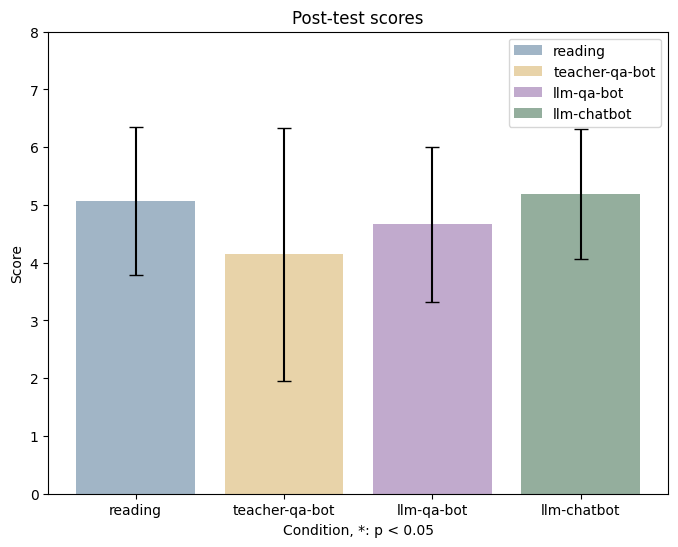

In [11]:
colors = ['#A1B5C6', '#E8D3A9', '#C1AACD', '#94AE9D']
# Create a bar chart for post-test scores
fig, ax = plt.subplots(figsize=(8, 6))

# Set the title, xlabel, and ylabel
ax.set_title("Post-test scores")  # Changed from fig.title to ax.set_title
ax.set_ylabel("Score")  # Changed from ax.ylabel to ax.set_ylabel
ax.set_xlabel("Condition, *: p < 0.05")  # Changed from ax.xlabel to ax.set_xlabel

# Set the y-axis limits
ax.set_ylim(0, 8)  # Changed from ax.ylim to ax.set_ylim

# Plot the bar chart
ax.bar(CONDITIONS, [np.mean(s) for s in group_scores], yerr=[np.std(s, ddof=1) for s in group_scores], capsize=5, color=colors)
print(ax.containers[1])
ax.containers[1].set_label('_nolegend')
for bar, tick_label in zip(ax.containers[1], ax.get_xticklabels()):
    bar.set_label(tick_label.get_text())
ax.legend()

plt.show()

In [12]:
# NOTE: per question performance
def question_score(log, index):
    return int((log["knowledgeAnswers"]["q" + str(index)]["answer"] == log["knowledgeAnswers"]["q" + str(index)]["solution"]))

all_scores = []
for i in range(1, 8):
    print(logs[0]["knowledgeAnswers"]["q" + str(i)]["question"])
    mean, err = get_avg_std_err([question_score(l, i) for l in logs])
    print("Overall average:  " + str(round(mean, 2)) + "  ± " + str(round(err, 2)))
    print("")
    group_scores = []
    for c in CONDITIONS:
        group = [l for l in logs if l["condition"] == c]
        group_scores.append([question_score(l, i) for l in group])
        mean, err = get_avg_std_err(group_scores[-1])
        print(c + " average:  " + str(round(mean, 2)) + "  ± " + str(round(err, 2)))
    all_scores.append(group_scores)
    _, p_value = f_oneway(*group_scores)
    print("ANOVA p-value:", round(p_value, 3))


    print("")

    # performe Broferroni correction
    print("Broferroni correction")
    for i in range(len(group_scores)):
        for j in range(i + 1, len(group_scores)):
            _, p_value = f_oneway(group_scores[i], group_scores[j])
            print(CONDITIONS[i] + " vs " + CONDITIONS[j] + " p-value:", round(p_value, 3))
    print("")


<span>Q1: Which of the following is the correct sequence of events?<br/><div class="MuiBox-root css-1voambi"><div class="MuiBox-root css-em1acu"><img class="MuiCardMedia-root MuiCardMedia-media MuiCardMedia-img css-rhsghg" src="/static/media/sequence_question.bb72c24760c87213cb74.jpg" width="727px" height="201px" alt="Response options."/></div><div class="MuiBox-root css-1kmcw8"><p class="MuiTypography-root MuiTypography-body2 MuiTypography-gutterBottom css-bv2e4m"><b>Figure <!-- -->2</b> <!-- -->Response options.</p></div></div></span>
Overall average:  0.62  ± 0.06

reading average:  0.67  ± 0.13
teacher-qa-bot average:  0.71  ± 0.18
llm-qa-bot average:  0.6  ± 0.13
llm-chatbot average:  0.57  ± 0.11
ANOVA p-value: 0.896

Broferroni correction
reading vs teacher-qa-bot p-value: 0.833
reading vs llm-qa-bot p-value: 0.716
reading vs llm-chatbot p-value: 0.576
teacher-qa-bot vs llm-qa-bot p-value: 0.624
teacher-qa-bot vs llm-chatbot p-value: 0.521
llm-qa-bot vs llm-chatbot p-value: 0.86

C:\Users\robin\AppData\Local\Temp\ipykernel_51768\1294273286.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i - 1].set_yticklabels([ "Reading", "Teacher-QA-Bot", "LLM-QA-Bot", "LLM-Chatbot"])


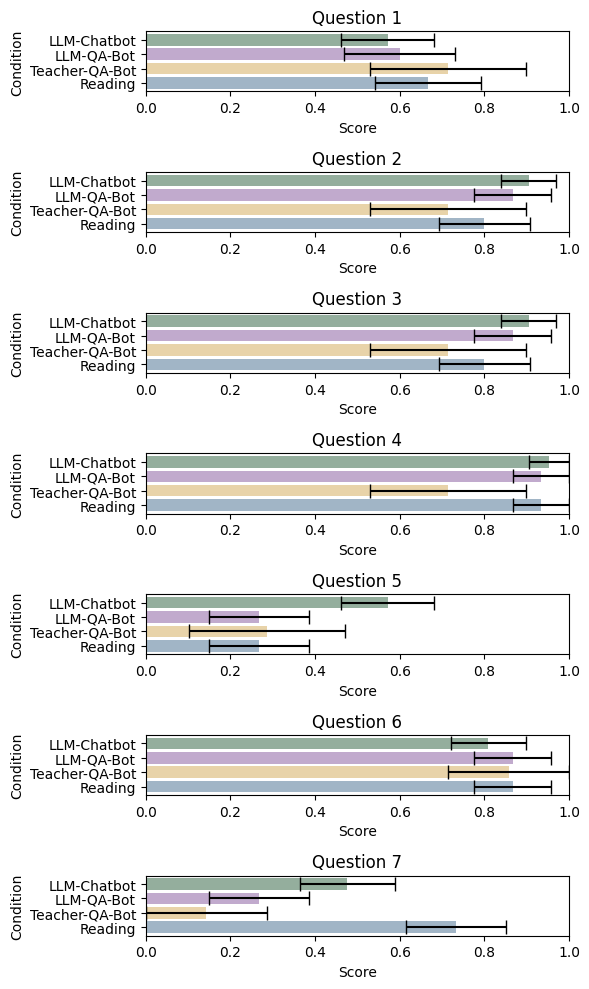

In [13]:
# plot a horizontal bar chart for each question as a subplot and within each subplot, there are 4 bars for 4 conditions, each condion has a mean and std and using a different color
fig, axs = plt.subplots(7, 1, figsize=(6, 10))
for i in range(1, 8):
    axs[i - 1].set_title("Question " + str(i))
    # axs[i - 1].set_title(logs[0]["knowledgeAnswers"]["q" + str(i)]["question"])
    axs[i - 1].set_ylabel("Condition")
    axs[i - 1].set_xlabel("Score")
    axs[i - 1].set_xlim(0, 1)
    # axs[i - 1].set_xticks([0, 1])
    # axs[i - 1].set_xticklabels(["0", "1"])
    axs[i - 1].set_yticklabels([ "Reading", "Teacher-QA-Bot", "LLM-QA-Bot", "LLM-Chatbot"])
    axs[i - 1].barh(["Reading", "Teacher-QA-Bot", "LLM-QA-Bot", "LLM-Chatbot"], [np.mean(s) for s in  all_scores[i-1]], xerr=[np.std(s, ddof=1) / np.sqrt(len(s)) for s in all_scores[i-1]], capsize=5, color=colors)
plt.tight_layout()
plt.show()

## Evaluate Free-Response Questino

In [14]:
print("")
for c in CONDITIONS:
    print(c)
    group = [l for l in logs if l["condition"] == c]
    for log in group:
        print(log["knowledgeAnswers"]["q8"]["answer"])
    print("")


reading
Protein breaks down to amino acids which the body converts into energy.
Protein synthesis is very necessary because our bodies would not be able to function without it.  Protein helps produce amino acids and enzymes, like those produced in the pancreas, that are necessary for us to survive.
for detoxification
Protein synthesis is necessary for our body because without proteins, we would be unable to rebuild our own cells, such as skin cells and muscle cells. For example, when we fall and scrape our leg, ribosomes must synthesize new cells to fill in the gap left by the injury.
to keep cells functioning
Protein Synthesis is necessary to form amino acids. It's how DNA messages information to mRNA which translates the ribosomes to form the amino acids. That's how our DNA sequence strands are made that makes us unique and alive. Without amino acids, there would be no life.
Protein is necessary for many of the cells in our body to function, and the protein in many foods that we int

## Evaluate UX Survey

<span>Q1: I already knew most of this material before the session.</span>
Overall average:  2.55  ± 0.21

reading average:  2.53  ± 0.41
teacher-qa-bot average:  3.0  ± 0.58
llm-qa-bot average:  2.2  ± 0.3
llm-chatbot average:  2.67  ± 0.43
ANOVA p-value: 0.729

Broferroni correction
reading vs teacher-qa-bot p-value: 0.525
reading vs llm-qa-bot p-value: 0.517
reading vs llm-chatbot p-value: 0.831
teacher-qa-bot vs llm-qa-bot p-value: 0.185
teacher-qa-bot vs llm-chatbot p-value: 0.689
llm-qa-bot vs llm-chatbot p-value: 0.42

<span>Q2: It was difficult to learn this lesson.</span>
Overall average:  4.34  ± 0.25

reading average:  4.47  ± 0.47
teacher-qa-bot average:  4.0  ± 0.79
llm-qa-bot average:  4.93  ± 0.51
llm-chatbot average:  3.95  ± 0.41
ANOVA p-value: 0.461

Broferroni correction
reading vs teacher-qa-bot p-value: 0.596
reading vs llm-qa-bot p-value: 0.506
reading vs llm-chatbot p-value: 0.413
teacher-qa-bot vs llm-qa-bot p-value: 0.323
teacher-qa-bot vs llm-chatbot p-value: 0

c:\Programme\miniconda3\envs\ck12\Lib\site-packages\scipy\stats\_stats_py.py:3895: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\robin\AppData\Local\Temp\ipykernel_51768\3735982730.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i - 1].set_yticklabels([ "Reading", "Teacher-QA-Bot", "LLM-QA-Bot", "LLM-Chatbot"])


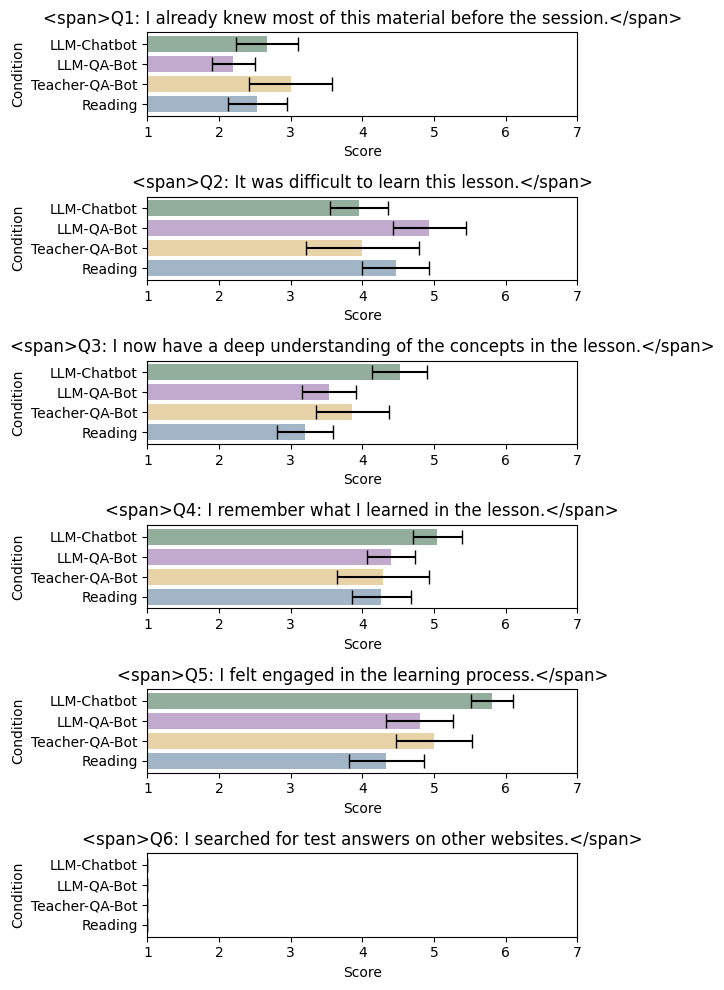

In [15]:
# First 6 UX questions
def ux_score(log, index):
    answer = log["surveyAnswers"]["q" + str(index)]["answer"]
    return LIKERT_CONVERTER[answer]

all_scores = []
for i in range(1, 7):
    print(logs[0]["surveyAnswers"]["q" + str(i)]["question"])

    mean, err = get_avg_std_err([ux_score(l, i) for l in logs])
    print("Overall average:  " + str(round(mean, 2)) + "  ± " + str(round(err, 2)))
    print("")
    group_scores = []
    for c in CONDITIONS:
        group = [l for l in logs if l["condition"] == c]
        group_scores.append([ux_score(l, i) for l in group])
        mean, err = get_avg_std_err(group_scores[-1])
        print(c + " average:  " + str(round(mean, 2)) + "  ± " + str(round(err, 2)))
    all_scores.append(group_scores)
    _, p_value = f_oneway(*group_scores)
    print("ANOVA p-value:", round(p_value, 3))

    print("")
    # performe Broferroni correction
    print("Broferroni correction")
    for i in range(len(group_scores)):
        for j in range(i + 1, len(group_scores)):
            _, p_value = f_oneway(group_scores[i], group_scores[j])
            print(CONDITIONS[i] + " vs " + CONDITIONS[j] + " p-value:", round(p_value, 3))
    print("")
    
# plot a horizontal bar chart for each question as a subplot and within each subplot, there are 4 bars for 4 conditions, each condion has a mean and std and using a different color

fig, axs = plt.subplots(6, 1, figsize=(6, 10))
for i in range(1, 7):
    # axs[i - 1].set_title("Question " + str(i))
    axs[i - 1].set_title(logs[0]["surveyAnswers"]["q" + str(i)]["question"])
    axs[i - 1].set_ylabel("Condition")
    axs[i - 1].set_xlabel("Score")
    axs[i - 1].set_xlim(1, 7)
    axs[i - 1].set_xticks([1, 2, 3, 4, 5, 6, 7])
    axs[i - 1].set_xticklabels(["1", "2", "3", "4", "5", "6", "7"])
    axs[i - 1].set_yticklabels([ "Reading", "Teacher-QA-Bot", "LLM-QA-Bot", "LLM-Chatbot"])
    axs[i - 1].barh(["Reading", "Teacher-QA-Bot", "LLM-QA-Bot", "LLM-Chatbot"], [np.mean(s) for s in  all_scores[i-1]], xerr=[np.std(s, ddof=1) / np.sqrt(len(s)) for s in all_scores[i-1]], capsize=5, color=colors)
plt.tight_layout()
plt.show()


In [16]:
# chatbot qs
# handle q8 n/a
all_scores = []
for i in range(7, 15):
    if i == 8:
        continue
    print(logs[0]["surveyAnswers"]["q" + str(i)]["question"])
    group_scores = []
    for c in ['teacher-qa-bot', 'llm-qa-bot', 'llm-chatbot']:
        group = [l for l in logs if l["condition"] == c]
        group_scores.append([ux_score(l, i) for l in group])
        mean, err = get_avg_std_err(group_scores[-1])
        print(c + " average:  " + str(round(mean, 2)) + "  ± " + str(round(err, 2)))
    all_scores.append(group_scores)
    _, p_value = f_oneway(*group_scores)
    print("ANOVA p-value:", round(p_value, 3))
    print("")

    CONDS = ['teacher-qa-bot', 'llm-qa-bot', 'llm-chatbot']
    # performe Broferroni correction
    print("Broferroni correction")
    for i in range(len(group_scores)):
        for j in range(i + 1, len(group_scores)):
            _, p_value = f_oneway(group_scores[i], group_scores[j])
            print(CONDS[i] + " vs " + CONDS[j] + " p-value:", round(p_value, 3))
    print("")

<span>Q7: I found the chatbot interrupting my learning process.</span>
teacher-qa-bot average:  2.71  ± 0.64
llm-qa-bot average:  2.67  ± 0.45
llm-chatbot average:  2.19  ± 0.34
ANOVA p-value: 0.626

Broferroni correction
teacher-qa-bot vs llm-qa-bot p-value: 0.953
teacher-qa-bot vs llm-chatbot p-value: 0.46
llm-qa-bot vs llm-chatbot p-value: 0.399

<span>Q8: Interacting with the chatbot improved my understanding of the lesson.</span>
teacher-qa-bot average:  4.43  ± 0.65
llm-qa-bot average:  4.4  ± 0.4
llm-chatbot average:  5.81  ± 0.24
ANOVA p-value: 0.007

Broferroni correction
teacher-qa-bot vs llm-qa-bot p-value: 0.969
teacher-qa-bot vs llm-chatbot p-value: 0.018
llm-qa-bot vs llm-chatbot p-value: 0.003

<span>Q9: Interacting with the chatbot helped me remember the lesson.</span>
teacher-qa-bot average:  4.43  ± 0.65
llm-qa-bot average:  4.33  ± 0.42
llm-chatbot average:  5.76  ± 0.22
ANOVA p-value: 0.007

Broferroni correction
teacher-qa-bot vs llm-qa-bot p-value: 0.901
teacher-q

C:\Users\robin\AppData\Local\Temp\ipykernel_51768\1035338422.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i - 1].set_yticklabels(["Teacher-QA-Bot", "LLM-QA-Bot", "LLM-Chatbot"])


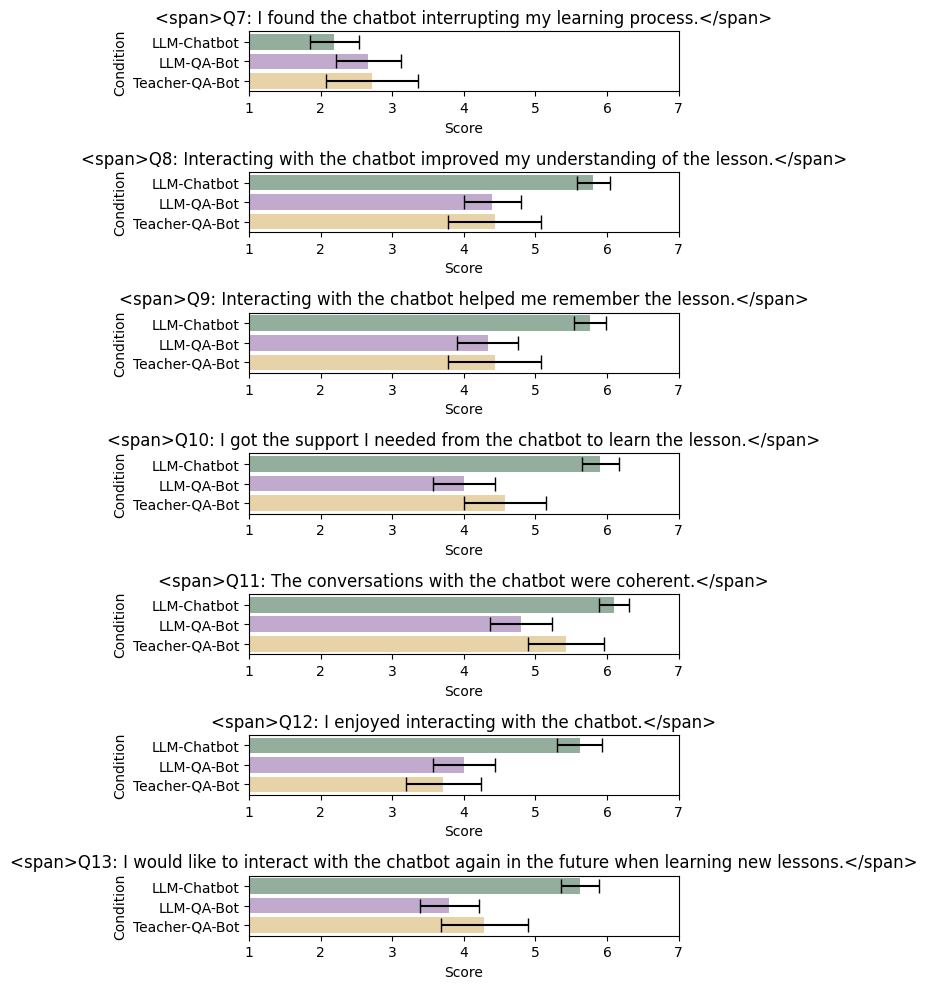

In [17]:
# plot a horizontal bar chart for each question as a subplot and within each subplot, there are 4 bars for 4 conditions, each condion has a mean and std and using a different color
colors = ['#E8D3A9', '#C1AACD', '#94AE9D']
offset = 0
fig, axs = plt.subplots(7, 1, figsize=(6, 10))
for i in range(1, 8):
    if i == 2:
        offset +=1
    # axs[i - 1].set_title("Question " + str(i))
    axs[i - 1].set_title(logs[0]["surveyAnswers"]["q" + str(i+6+offset)]["question"])
    axs[i - 1].set_ylabel("Condition")
    axs[i - 1].set_xlabel("Score")
    axs[i - 1].set_xlim(1, 7)
    axs[i - 1].set_xticks([1, 2, 3, 4, 5, 6, 7])
    axs[i - 1].set_xticklabels(["1", "2", "3", "4", "5", "6", "7"])
    axs[i - 1].set_yticklabels(["Teacher-QA-Bot", "LLM-QA-Bot", "LLM-Chatbot"])
    axs[i - 1].barh(["Teacher-QA-Bot", "LLM-QA-Bot", "LLM-Chatbot"], [np.mean(s) for s in  all_scores[i-1]], xerr=[np.std(s, ddof=1) / np.sqrt(len(s)) for s in all_scores[i-1]], capsize=5, color=colors)
plt.tight_layout()
plt.show()

In [18]:
# print free response questions
for c in ['llm-chatbot', 'llm-qa-bot', 'teacher-qa-bot', 'reading']:
    print(c)
    group = [l for l in logs if l["condition"] == c]
    for i, e in enumerate(group):
        if "answer" in group[i]["surveyAnswers"]["q15"]:
            print(i, group[i]["surveyAnswers"]["q15"]["answer"])
    print("")


llm-chatbot
7 I enjoyed using the chatbot.
10 Brilliant idea!
14 no
17 I had connection issues while taking this survey. The chatbots also broke down and stopped responding at one point
18 Thank you

llm-qa-bot
1 
2 As a layperson, I found it difficult to absorb these scientific concepts and what would have helped me more is if the chatbot would help me come up with more simple examples or memory tricks to help me remember the terms. It felt as if the chatbot was merely rehashing the information on the textbook page and not really adding much to the learning experience. Perhaps it would have felt different on a subject that was more familiar to me. 
9 Chatbot first said that I had a great answer but then it only thanked me for the response so I thought it didn't like my answers. Was I able to ask the Chatbot question? I hadn't thought so. I felt like I could regurgitate what the lesson said without understanding it and the chatbot would have been fine.
10 i feel like not all the questi

## Time on Learning Page

In [19]:
def time_on_learning(log):
    learning = datetime.strptime(log["timestamps"]["enterMain"], FORMAT)
    knowledge = datetime.strptime(log["timestamps"]["enterKnowledge"], FORMAT)
    return round((knowledge - learning).total_seconds() / 60.0, 1)

print("Time on lesson section")
for c in CONDITIONS:
    group = [l for l in logs if l["condition"] == c]
    print(c, np.median([time_on_learning(l) for l in group]))

Time on lesson section
reading 3.0
teacher-qa-bot 12.2
llm-qa-bot 14.4
llm-chatbot 20.4


In [20]:
group = [l for l in logs if l["condition"] == 'llm-chatbot']
group_scores = [ux_score(l, 8) for l in group]
mean, err = get_avg_std_err(group_scores)
print(mean, err)

2.142857142857143 0.31080321661106136


## Further Analysis

In [21]:
# tab switches
def exam_switches(log):
    switches = 0
    knowledge = datetime.strptime(log["timestamps"]["enterKnowledge"], FORMAT)
    survey = datetime.strptime(log["timestamps"]["enterSurvey"], FORMAT)
    if not "tabSwitches" in log:
        return 0
    for switch in log["tabSwitches"]:
        if switch[0] == "exit":
            time = datetime.strptime(switch[1], FORMAT)
            if (knowledge < time) and (time < survey):
                switches += 1
    return switches

filtered_logs = []
for c in ['llm-chatbot', 'llm-qa-bot', 'teacher-qa-bot', 'reading']:
    print(c)
    group = [l for l in logs if l["condition"] == c]
    for log in group:
        print(exam_switches(log))
        if exam_switches(log) == 0:
            filtered_logs.append(log)
    print("")
# logs = filtered_logs

llm-chatbot
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0

llm-qa-bot
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0

teacher-qa-bot
0
0
0
0
0
0
0

reading
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0



In [23]:
# conversations switches
def compile_dialog(log):
    messages = []
    for m in log["chatLog"]["current"]["main"]:
        time = datetime.strptime(m["date"], FORMAT)
        messages.append((time, m["text"]))
    for m in log["chatLog"]["current"].get("help", []):
        time = datetime.strptime(m["date"], FORMAT)
        messages.append((time, m["text"]))
    #for m in log["chatLog"]["current"].get("supervisor", []):
    #    time = datetime.strptime(m["date"], DATEFORMAT)
    #    messages.append((time, m.get("text", "Professor: NO LLM RESPONSE")))
    messages.sort()
    for m in messages:
        print(m[1])


for c in ['teacher-qa-bot']:
    print(c)
    group = [l for l in logs if l["condition"] == c]
    for i, log in enumerate(group):
        print("===========================================================")
        print(i)
        print("===========================================================")
        compile_dialog(log)
        print("")
        print("")

teacher-qa-bot
0
Nice to meet you! I am Ruffle. I can help you reflect on the material.
Explain the principle of “form follows function”, providing one example of how this principle applies to the structure and organization of eukaryotic cells.
ribosomes in eukaryotic cells come in a form that is in high numbers so they can provide the function of synthesizing a lot of protein
Thank you for the response! As a reference, here is our model solution:
The principle of form follows function means that the function of a particular structure is specifically designed to help the structure carry out its particular function. There are many examples where a type of eukaryotic cell is enriched in a particular structure or organelle to optimize its ability to perform a particular function. These include:  (A)	Cells that need to make a lot of proteins, like pancreatic cells that make a high quantity of digestive enzymes, contain many ribosomes, the structure responsible for protein synthesis.  (B) M

In [ ]:

def num_messages(log):
    if log["condition"] == "treatment":
        return sum([e["isUser"] for e in log["chatLog"]["current"]["main"]])
    else:
        return "-"

def num_help(log):
    if log["condition"] == "treatment":
        if "help" in log["chatLog"]["current"]:
            return len(log["chatLog"]["current"]["help"])
        else:
            return 0
    else:
        return "-"

def time_total(log):
    learning = datetime.strptime(log["timestamps"]["enterMain"], DATEFORMAT)
    completion = datetime.strptime(log["timestamps"]["completion"], DATEFORMAT)
    return round((completion - learning).total_seconds() / 60.0, 1)

def time_on_exam(log):
    knowledge = datetime.strptime(log["timestamps"]["enterKnowledge"], DATEFORMAT)
    survey = datetime.strptime(log["timestamps"]["enterSurvey"], DATEFORMAT)
    return round((survey - knowledge).total_seconds() / 60.0, 1)

def total_switches(log):
    switches = 0
    learning = datetime.strptime(log["timestamps"]["enterMain"], DATEFORMAT)
    if not "tabSwitches" in log:
        return 0
    for switch in log["tabSwitches"]:
        if switch[0] == "exit":
            time = datetime.strptime(switch[1], DATEFORMAT)
            if (learning < time):
                switches += 1
    return switches

### Compile results

In [ ]:
# performance df
perf_df = pd.DataFrame()
perf_df["surveyToken"] = [l["surveyToken"] for l in rlogs]
perf_df["condition"] = [l["condition"] for l in rlogs]
perf_df["completed_survey"] = [completed_survey(l) for l in rlogs]
perf_df["time_learning"] = [time_on_learning(l) for l in rlogs]
perf_df["num_messages"] = [num_messages(l) for l in rlogs]
perf_df["num_help"] = [num_help(l) for l in rlogs]
perf_df["test_score"] = [test_score(l) for l in rlogs]
perf_df["total_switches"] = [total_switches(l) for l in rlogs]
perf_df["exam_switches"] = [exam_switches(l) for l in rlogs]
perf_df["time_exam"] = [time_on_exam(l) for l in rlogs]
perf_df["time_total"] = [time_total(l) for l in rlogs]
perf_df["creation_time"] = [l["timestamps"]["creation"] for l in rlogs]
perf_df["completion_time"] = [l["timestamps"]["completion"] for l in rlogs]

perf_df = perf_df.sort_values("condition")
perf_df.to_csv("./tmp/perf_tmp.csv", index=False)
perf_df